importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Scikit-learn Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# XGBoost
import xgboost as xgb

# Set pandas display option
pd.set_option('display.max_colwidth', None)



In [2]:
from google.colab import files
uploaded = files.upload()

Saving restaurant_reviews.csv to restaurant_reviews.csv


## data loading and cleaning

In [3]:
import pandas as pd

# Load the dataset using the correct relative path
df = pd.read_csv('restaurant_reviews.csv')

# Select the necessary columns and drop rows with missing ratings
df = df[['Review','Rating']]
df = df.dropna(subset=["Rating", "Review"])

# Ensure ratings are digits and convert the column to integer type
df = df[df["Rating"].apply(lambda x: str(x).isdigit())]
df["Rating"] = df["Rating"].astype(int)

# Ensure the 'Review' column is always a string
df['Review'] = df['Review'].astype(str)

print("Data loaded and cleaned successfully.")
print(f"Shape of the dataframe: {df.shape}")
df.head()



Data loaded and cleaned successfully.
Shape of the dataframe: (9810, 2)


,Review,Rating
0,"The ambience was good, food was quite good . had Saturday lunch , which was cost effective .\r\nGood place for a sate brunch. One can also chill with friends and or parents.\r\nWaiter Soumen Das was really courteous and helpful.",5
1,Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service,5
2,A must try.. great food great ambience. Thnx for the service by Pradeep and Subroto. My personal recommendation is Penne Alfredo Pasta:) ....... Also the music in the background is amazing.,5
3,"Soumen das and Arun was a great guy. Only because of their behavior and sincerety, And good food off course, I would like to visit this place again.",5
4,Food is good.we ordered Kodi drumsticks and basket mutton biryani. All are good. Thanks to Pradeep. He served well. We enjoyed here. Ambience is also very good.,5


MAP rating and setiment

In [4]:
def map_sentiment(rating):
    if rating > 3:
        return "positive"
    elif rating < 3:
        return "negative"
    else:
        return "neutral"

df["Sentiment"] = df["Rating"].apply(map_sentiment)

print("Sentiment column created.")
df.head()


Sentiment column created.


,Review,Rating,Sentiment
0,"The ambience was good, food was quite good . had Saturday lunch , which was cost effective .\r\nGood place for a sate brunch. One can also chill with friends and or parents.\r\nWaiter Soumen Das was really courteous and helpful.",5,positive
1,Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service,5,positive
2,A must try.. great food great ambience. Thnx for the service by Pradeep and Subroto. My personal recommendation is Penne Alfredo Pasta:) ....... Also the music in the background is amazing.,5,positive
3,"Soumen das and Arun was a great guy. Only because of their behavior and sincerety, And good food off course, I would like to visit this place again.",5,positive
4,Food is good.we ordered Kodi drumsticks and basket mutton biryani. All are good. Thanks to Pradeep. He served well. We enjoyed here. Ambience is also very good.,5,positive


check class balances


/tmp/ipython-input-4068568349.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=df, palette="coolwarm", order=['positive', 'negative', 'neutral'])


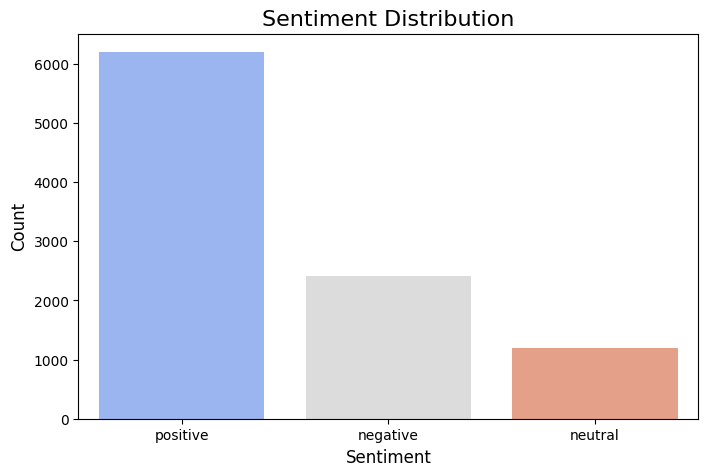

Sentiment Value Counts (Normalized):
Sentiment
positive    0.631906
negative    0.246585
neutral     0.121509
Name: proportion, dtype: float64


In [5]:
# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="Sentiment", data=df, palette="coolwarm", order=['positive', 'negative', 'neutral'])
plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Display the exact value counts
print("Sentiment Value Counts (Normalized):")
print(df["Sentiment"].value_counts(normalize=True))


text cleaning function

In [6]:
# Download necessary NLTK data (only needs to be done once)
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()

    # Tokenize the text
    words = text.split()

    # Remove stopwords and lemmatize
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return " ".join(lemmatized_words)

print("Preprocessing function is ready.")


Preprocessing function is ready.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


preprocessing

In [7]:
# Apply the preprocessing function to the Review column
# This may take a moment to run
df['Processed_Review'] = df['Review'].apply(preprocess_text)

print("Text preprocessing complete. Here's a before-and-after example:")
print("\n--- ORIGINAL REVIEW ---")
print(df['Review'].iloc[0])
print("\n--- PROCESSED REVIEW ---")
print(df['Processed_Review'].iloc[0])


Text preprocessing complete. Here's a before-and-after example:

--- ORIGINAL REVIEW ---
The ambience was good, food was quite good . had Saturday lunch , which was cost effective .
Good place for a sate brunch. One can also chill with friends and or parents.
Waiter Soumen Das was really courteous and helpful.

--- PROCESSED REVIEW ---
ambience good food quite good saturday lunch cost effective good place sate brunch one also chill friend parent waiter soumen da really courteous helpful


TDF-IDF vectorization

In [8]:
# Initialize the TF-IDF Vectorizer
# max_features limits the vocabulary size to the top 5000 words
# ngram_range=(1,2) considers both single words and pairs of words (bigrams)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Create the feature matrix (X) and target vector (y)
X = tfidf.fit_transform(df['Processed_Review'])
y = df['Sentiment']

print("TF-IDF vectorization complete.")
print(f"Shape of the feature matrix (X): {X.shape}")


TF-IDF vectorization complete.
Shape of the feature matrix (X): (9810, 5000)


split data

In [9]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42, # for reproducibility
    stratify=y       # IMPORTANT for imbalanced data
)

print("Data splitting complete.")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Data splitting complete.
Training data shape: (7848, 5000)
Testing data shape: (1962, 5000)


Apply SMOTE for Resampling

In [10]:
print(f"Original training set distribution: {Counter(y_train)}")

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training set distribution: {Counter(y_train_resampled)}")


Original training set distribution: Counter({'positive': 4959, 'negative': 1935, 'neutral': 954})
Resampled training set distribution: Counter({'negative': 4959, 'positive': 4959, 'neutral': 4959})


Logistic regression

In [11]:
# Initialize the Logistic Regression model
# We increase max_iter to ensure convergence
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the resampled training data
model.fit(X_train_resampled, y_train_resampled)

print("Model training complete.")


Model training complete.


Random forest

In [13]:
print("--- Training and Evaluating Random Forest ---")

# Initialize LabelEncoder
le = LabelEncoder()

# Encode the target variables
y_train_resampled_encoded = le.fit_transform(y_train_resampled)
y_test_encoded = le.transform(y_test)

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled_encoded)

# Make predictions and evaluate
y_pred_rf = rf_model.predict(X_test)
print("\n--- Random Forest Evaluation ---")
print(classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_))

--- Training and Evaluating Random Forest ---

--- Random Forest Evaluation ---
              precision    recall  f1-score   support

    negative       0.80      0.78      0.79       484
     neutral       0.35      0.20      0.25       238
    positive       0.84      0.92      0.88      1240

    accuracy                           0.80      1962
   macro avg       0.66      0.63      0.64      1962
weighted avg       0.77      0.80      0.78      1962



XG Boost

In [14]:
print("--- Training and Evaluating XGBoost ---")

# Initialize and train the model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled_encoded)

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(X_test)
print("\n--- XGBoost Evaluation ---")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=le.classes_))



--- Training and Evaluating XGBoost ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:05:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Evaluation ---
              precision    recall  f1-score   support

    negative       0.76      0.83      0.79       484
     neutral       0.42      0.32      0.36       238
    positive       0.88      0.89      0.89      1240

    accuracy                           0.81      1962
   macro avg       0.69      0.68      0.68      1962
weighted avg       0.80      0.81      0.80      1962



model eval

In [17]:
# Make predictions for Logistic Regression
y_pred_log_reg = model.predict(X_test)
y_pred_log_reg_encoded = le.transform(y_pred_log_reg)

# Calculate F1 scores for the neutral class for each model
f1_neutral_log_reg = f1_score(y_test_encoded, y_pred_log_reg_encoded, labels=[le.transform(['neutral'])[0]], average='macro')
f1_neutral_rf = f1_score(y_test_encoded, y_pred_rf, labels=[le.transform(['neutral'])[0]], average='macro')
f1_neutral_xgb = f1_score(y_test_encoded, y_pred_xgb, labels=[le.transform(['neutral'])[0]], average='macro')

print(f"Logistic Regression Neutral F1-Score: {f1_neutral_log_reg:.4f}")
print(f"Random Forest Neutral F1-Score: {f1_neutral_rf:.4f}")
print(f"XGBoost Neutral F1-Score: {f1_neutral_xgb:.4f}")

# For this example, let's assume XGBoost performed best and analyze its errors
print("\n--- Analyzing Misclassified Neutral Reviews (from XGBoost model) ---")

# Decode predictions back to string labels for analysis
y_pred_xgb_labels = le.inverse_transform(y_pred_xgb)

# Create a results DataFrame
results_df = pd.DataFrame({'True_Sentiment': y_test, 'Predicted_Sentiment': y_pred_xgb_labels})
results_df['Review'] = df.loc[y_test.index, 'Review']

# Filter for misclassified neutral reviews
misclassified_neutral = results_df[
    (results_df['True_Sentiment'] == 'neutral') &
    (results_df['Predicted_Sentiment'] != 'neutral')
]

print(f"\nNumber of misclassified neutral reviews: {len(misclassified_neutral)}")
print("Displaying 10 examples:")
print(misclassified_neutral.head(10))

Logistic Regression Neutral F1-Score: 0.4014
Random Forest Neutral F1-Score: 0.2546
XGBoost Neutral F1-Score: 0.3649

--- Analyzing Misclassified Neutral Reviews (from XGBoost model) ---

Number of misclassified neutral reviews: 161
Displaying 10 examples:
     True_Sentiment Predicted_Sentiment  \
4470        neutral            positive   
3885        neutral            negative   
333         neutral            positive   
3191        neutral            positive   
7881        neutral            positive   
4534        neutral            negative   
5937        neutral            negative   
4417        neutral            negative   
8218        neutral            positive   
8918        neutral            negative   

                                                                                                                                                                                                                                                                             